In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import itertools as it

# Resumo

Diversas doenças contagiosas apresentam um período de incubação do vírus antes de indivíduos expostos tornarem-se infecciosos, mas os modelos clássicos de contágio (SI, SIS, SIR) não incorporam esse atraso, o que pode levar a previsões imprecisas sobre a dinâmica de surtos. Este trabalho teve como objetivo geral analisar o impacto da inclusão de um estado de latência (estado exposto) nos modelos SEIS e SEIR, comparando-os aos seus análogos sem latência em termos de velocidade de propagação, altura e tempo até o pico de infecção, bem como tamanho final do surto. Quanto à metodologia, foi implementado em Python, via Jupyter Notebook, um resolvedor numérico baseado no método de Runge-Kutta de quarta ordem para integrar as equações diferenciais ordinárias que descrevem as transições de estado dos modelos. Foram modeladas diferentes circunstâncias de epidemias, variando parâmetros-chave (taxa de transmissão λ, taxa de progressão σ, taxa de recuperação μ) e geradas visualizações quantitativas dos perfis temporais de S, E, I e R. Os resultados evidenciaram que a latência adia significativamente o início do crescimento exponencial - proporcional a 1/σ - e “achata” a curva de infectados, reduzindo o pico e estendendo a duração do surto; alta transmissibilidade (λ) ainda resulta em picos elevados, mas há uma janela maior de aplicação para ações de intervenção; e taxas de recuperação elevadas (μ) diminuem o pico e aceleram a recuperação. Conclui-se que incluir o estado exposto em modelos epidemiológicos fornece previsões mais realistas para doenças com incubação, e corrobora quantitativamente políticas de quarentena e vacinação.

# Modelo SI (Susceptible-infected)

## Equação diferencial

$$ \frac{d\rho}{dt} = \lambda \left< k \right> \rho (1-\rho) $$

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\rho$ é a fração da população atualmente infectada.

## Solução analítica

Esse modelo possui solução analítica, que é dada pela equação:

$$
  \rho(t) = \frac
    {1}
    {
      1 +
      \left(\frac{1 - \rho_0}{\rho_0}\right)
      e^{-\lambda \langle k \rangle t}
    }
$$

Onde $ \rho_0 = \rho(t = 0) $, ou seja, a fração de infectados no momento
inicial.

## Plot do modelo SI por solução analítica

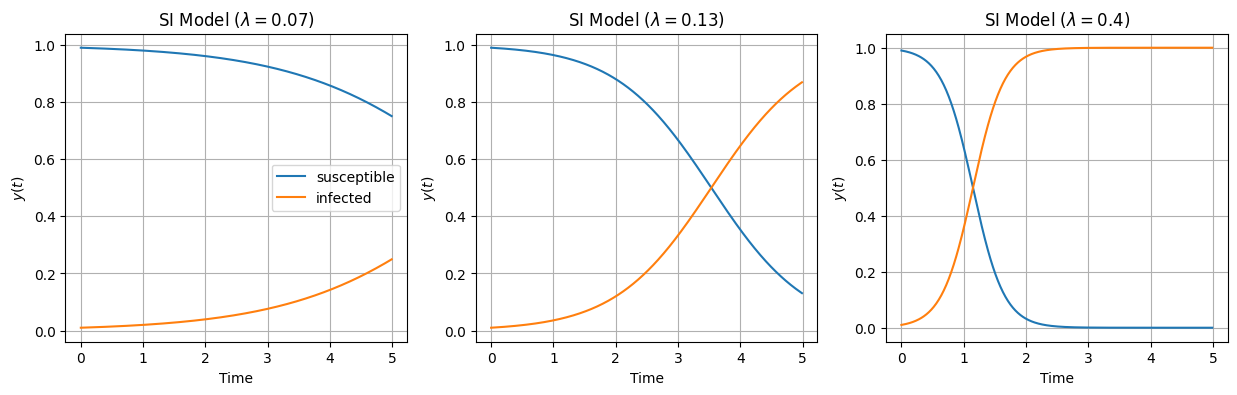

In [2]:
# Parameters for the analytical solution
num_steps = 500
h = 0.01

lmbd_values = [0.07, 0.13, 0.4]
k = 10

y0 = 0.01

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, lmbd in zip(axes.flat, lmbd_values):
    # Analytical solution
    values = 1 / (1 + (1 - y0) / y0 * np.exp(-lmbd * k * time))

    # Plot the analytical solution
    ax.plot(time, 1 - values, label='susceptible')
    ax.plot(time, values, label='infected')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SI Model ($\lambda = {lmbd}$)')
    ax.grid(True)

axes[0].legend()
plt.show()


# Modelo SIS (Susceptible-infected-susceptible)


## Equação diferencial

$$ \frac{d\rho}{dt} = \lambda \langle k \rangle \rho (1-\rho) - \mu \rho $$

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\rho$ é a fração da população atualmente infectada.
- $\mu$ é a taxa de cura.


## Solução analítica

Esse modelo possui solução analítica, que é dada pela equação:

$$
  \rho(t) = \frac
    {
      1 -
      \frac{\mu}{\lambda \langle k \rangle}}
    {
      1 +
      \left(\frac{1 - \frac{\mu}{\lambda \langle k \rangle} - \rho_0}{\rho_0}\right)
      e^{-\left(\lambda \langle k \rangle - \mu\right)t}
    }
$$

Onde $ \rho_0 = \rho(t = 0) $, ou seja, a fração de infectados no momento
inicial.

## Plot do modelo SIS por solução analítica

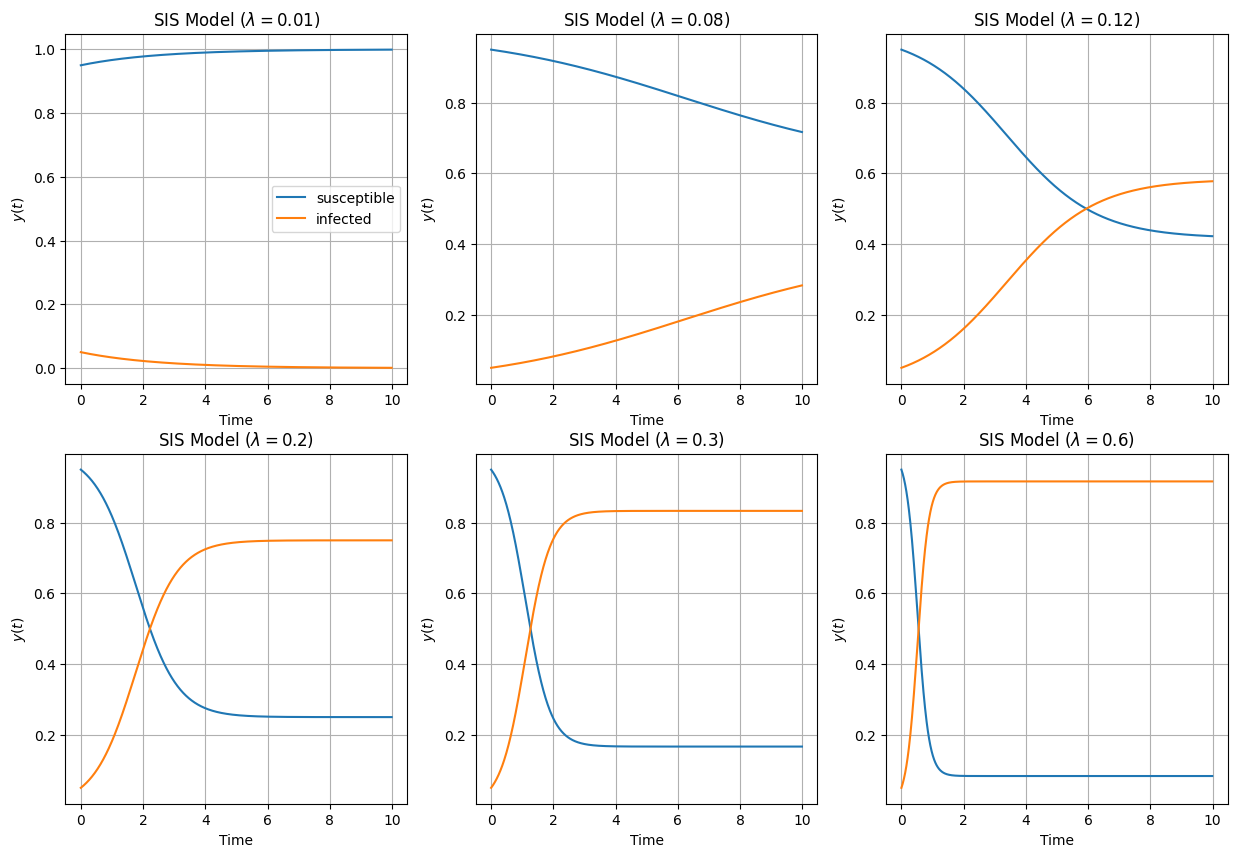

In [3]:
# Parameters for the analytical solution
num_steps = 1000
h = 0.01

lmbd_values = [0.01, 0.08, 0.12, 0.2, 0.3, 0.6]
k = 10
mu = 0.5

y0 = 0.05

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Analytical solution
for ax, lmbd in zip(axes.flat, lmbd_values):
    growth = 1 - (mu / (lmbd * k))
    values = (
        growth
        / (1 + (growth - y0) / y0 * np.exp(
            -(lmbd * k - mu) * time.reshape((num_steps, 1))
        ))
    )

    # Plot the analytical solution
    ax.plot(time, 1 - values, label='susceptible')
    ax.plot(time, values, label='infected')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SIS Model ($\lambda = {lmbd}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Soluções numéricas

Os modelos epidêmicos mais elaborados geralmente não podem ser integrados analiticamente,
isto é, expressões matemáticas que fornecem a solução exata são impossíveis de ser obtidas
a partir de manipulações algébricas. Nesses casos, devemos utilizar soluções numéricas, que
envolvem aproximações calculadas iterativamente. É aqui que entram os métodos de Runge-Kutta.

## Métodos Runge-Kutta

Família de métodos iterativos para a resolução numérica de equações diferenciais, incluindo o **método de Euler**.


### Comparação dos métodos de Runge-Kutta

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Comparison_of_the_Runge-Kutta_methods_for_the_differential_equation_%28red_is_the_exact_solution%29.svg/1920px-Comparison_of_the_Runge-Kutta_methods_for_the_differential_equation_%28red_is_the_exact_solution%29.svg.png)
_Gráfico: comparação dos métodos da família Runge-Kutta em relação à solução exata de $y'=\sin(t)^2 \cdot y$, com intervalo $h=0.5$. Fonte: https://en.wikipedia.org/wiki/Runge–Kutta_methods_

### Método de Euler (Runge-Kutta de ordem 1)

$ y_{n+1} = y_n + h \cdot f\left(t_n, y_n\right) $  
$ t_{n+1} = t_n + h $

### Método Runge-Kutta de ordem 4

$ y_{n+1} = y_n + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right) $  
$ t_{n+1} = t_n + h $

Onde:

$ k_1 = h \cdot f\left(t_n, y_n\right) $  
$ k_2 = h \cdot f\left(t_n + \frac{h}{2}, y_n + \frac{k_1}{2}\right) $  
$ k_1 = h \cdot f\left(t_n + \frac{h}{2}, y_n + \frac{k_2}{2}\right) $  
$ k_1 = h \cdot f\left(t_n + h, y_n + k_3\right) $

## Implementação dos métodos Runge-Kutta

In [4]:
import numpy as np
import numpy.typing as npt

def euler(f, t: float, y: npt.ArrayLike, h: float) -> np.ndarray:
    """Compute next y value(s) using the Euler method."""
    return y + h * f(t, y)

def runge_kutta(f, t: float, y: npt.ArrayLike, h: float) -> np.ndarray:
    """Compute next y value(s) using the Runge-Kutta method."""
    k1 = h * f(t      , y       )
    k2 = h * f(t + h/2, y + k1/2)
    k3 = h * f(t + h/2, y + k2/2)
    k4 = h * f(t + h  , y + k3  )

    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

def plot_method(method, f, y0: npt.ArrayLike, num_steps: int, h: float) -> np.ndarray:
    """Generate graph data for function `f` using `method`, with `num_steps` steps.

    y0 can be a scalar or an array, if you need to keep track of multiple
    variables.
    """
    values = np.empty(shape=(num_steps, *np.shape(y0)))
    values[0] = y0  # Setting initial value

    for i in range(num_steps - 1):
        y = values[i]
        t = i * h

        values[i + 1] = method(f, t, y, h)

    return values

## Plot do modelo SI por solução numérica

Relembrando, a equação diferencial que o descreve é:

$$ \frac{d\rho}{dt} = \lambda \left< k \right> \rho (1-\rho) $$

Definindo o número de passos do algoritmo iterativo como $500$, e
o intervalo $h$ como $0.01$, obtemos:

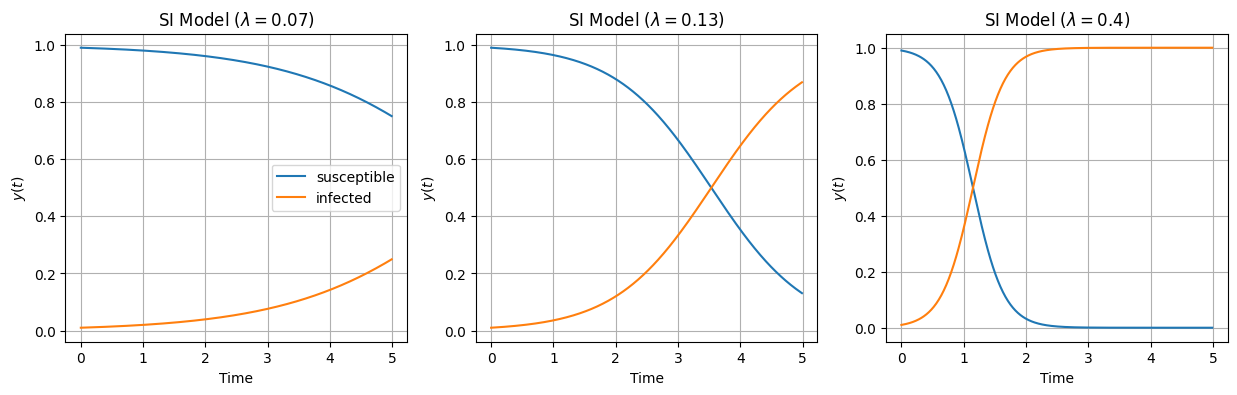

In [5]:
def si_model(lmbd: float, k: float):
    """Construct a function that represents the SI model"""
    return lambda _t, y: lmbd * k * y * (1 - y)

# Parameters for the numerical solution
num_steps = 500
h = 0.01

lmbd_values = [0.07, 0.13, 0.4]
k = 10

y0 = 0.01

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Numerical solution
for ax, lmbd in zip(axes.flat, lmbd_values):
    values = plot_method(runge_kutta, si_model(lmbd, k), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, 1 - values, label='susceptible')
    ax.plot(time, values, label='infected')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SI Model ($\lambda = {lmbd}$)')
    ax.grid(True)

axes[0].legend()
plt.show()

## Plot do modelo SIS por solução numérica

Relembrando, a equação diferencial que o descreve é:

$$ \frac{d\rho}{dt} = \lambda \left< k \right> \rho (1-\rho) - \mu \rho $$

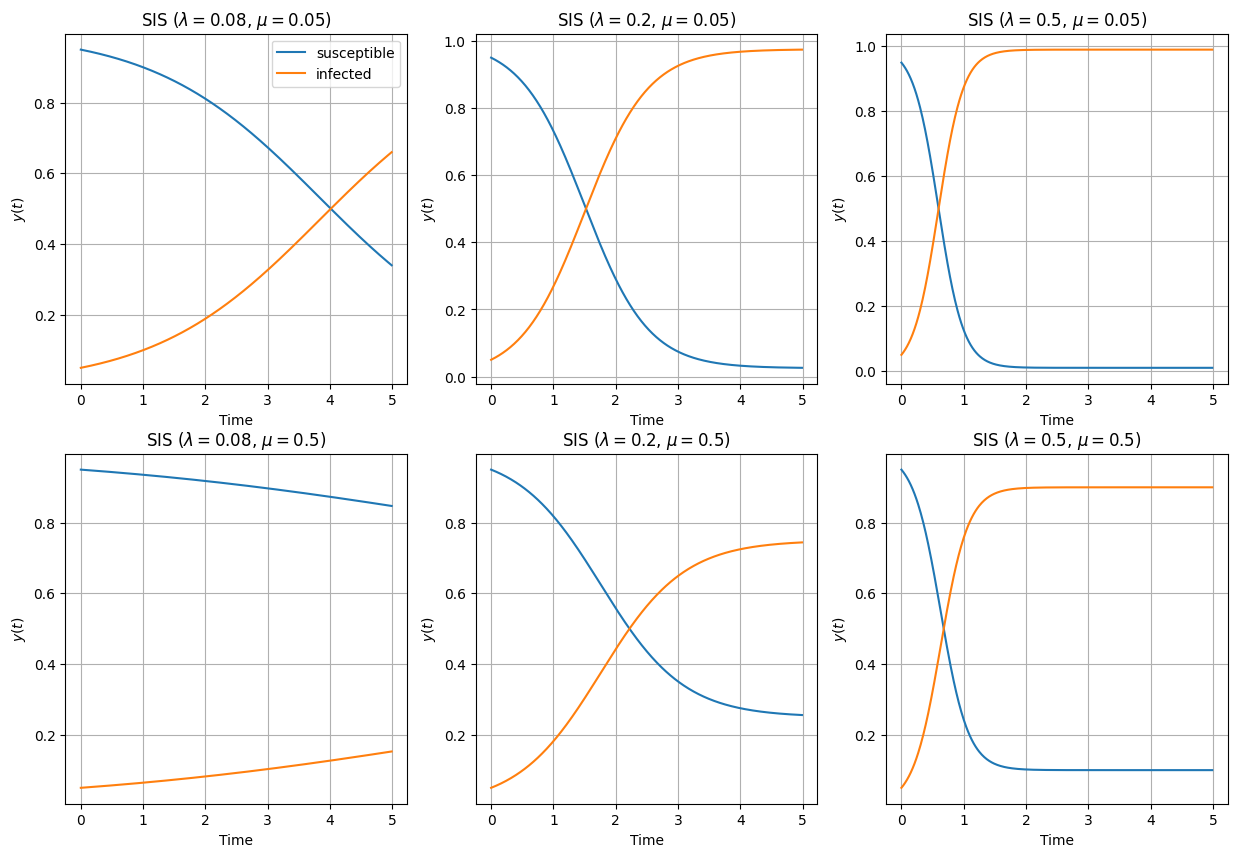

In [6]:
def sis_model(lmbd: float, k: float, mu: float):
    """Construct a function that represents the SIS model"""
    return lambda _t, y: lmbd * k * y * (1 - y) - mu * y

# Parameters for the numerical solution
num_steps = 500
h = 0.01

lmbd_values = [0.08, 0.2, 0.5]
mu_values = [0.05, 0.5]
k = 10

y0 = 0.05

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Numerical solution
for ax, (mu, lmbd) in zip(axes.flat, it.product(mu_values, lmbd_values)):
    values = plot_method(runge_kutta, sis_model(lmbd, k, mu), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, 1 - values, label='susceptible')
    ax.plot(time, values, label='infected')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SIS ($\lambda = {lmbd}$, $\mu = {mu}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Comparação entre as soluções analíticas e numéricas

Podemos comparar a precisão das soluções numéricas em relação à solução analítica (solução exata). Mais especificamente, vamos construir um gráfico com a solução analítica de referência, o método de Euler, e o método de Runge-Kutta. O intervalo $h$ foi aumentado artificialmente, para que as discrepâncias sejam visíveis claramente.

É possível notar que, mesmo assim, a solução por Runge-Kutta continua surpreendentemente precisa, enquanto o método de Euler luta para acompanhá-la. Por isso, o método de Runge-Kutta é perfeitamente adequado para simular os modelos subsequentes.

## Modelo SI

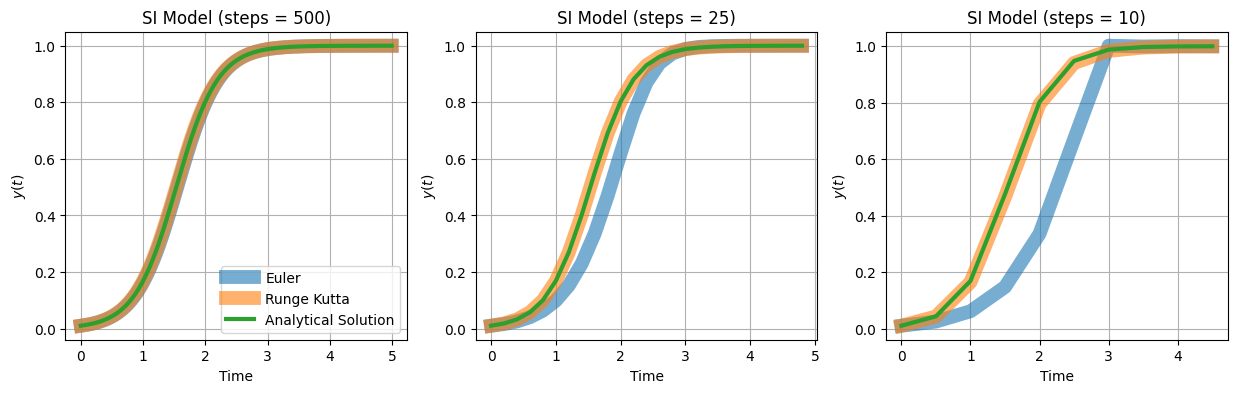

In [7]:
# Parameters for all solutions
h_values = [0.01, 0.2, 0.5]

lmbd = 0.3
k = 10
y0 = 0.01

# Create the figure and axes objects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, h in zip(axes.flat, h_values):
    num_steps = int(5 / h)

    # Time axis for all solutions
    time = np.arange(0, num_steps * h, h)

    # Numerical solutions
    values_euler = plot_method(euler, si_model(lmbd, k), y0, num_steps, h)
    values_runge_kutta = plot_method(runge_kutta, si_model(lmbd, k), y0, num_steps, h)

    # Analytical solution
    values_analytical = 1 / (1 + (1 - y0) / y0 * np.exp(-lmbd * k * time))

    # Plot all solutions on the same graph
    ax.plot(time, values_euler, label='Euler', linewidth=10, alpha=0.6)
    ax.plot(time, values_runge_kutta, label='Runge Kutta', linewidth=10, alpha=0.6)
    ax.plot(time, values_analytical, label='Analytical Solution', linewidth=3)

    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SI Model (steps = {num_steps})')
    ax.grid(True)

axes[0].legend()
plt.show()

## Modelo SIS

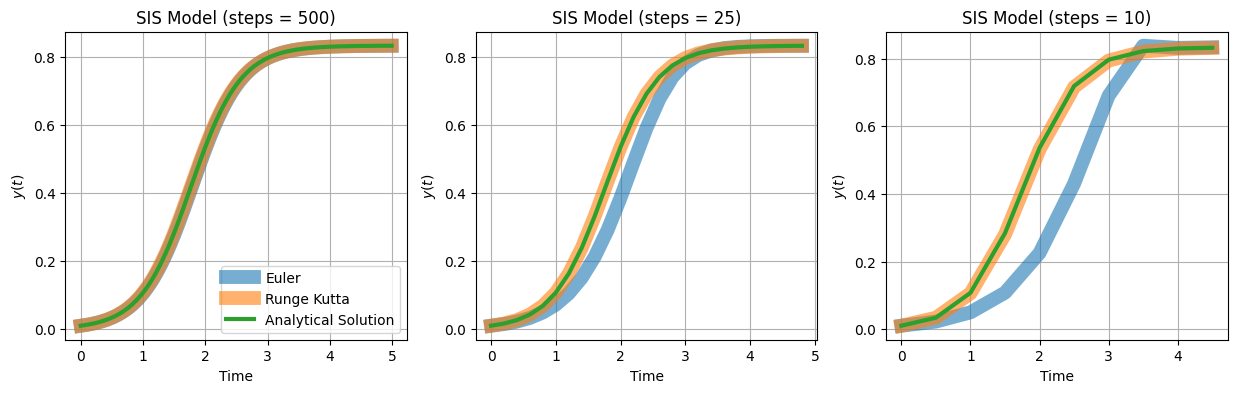

In [8]:
# Parameters for all solutions
h_values = [0.01, 0.2, 0.5]

lmbd = 0.3
k = 10
mu = 0.5
y0 = 0.01

# Create the figure and axes objects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, h in zip(axes.flat, h_values):
    num_steps = int(5 / h)

    # Time axis for all solutions
    time = np.arange(0, num_steps * h, h)

    # Numerical solution
    values_euler = plot_method(euler, sis_model(lmbd, k, mu), y0, num_steps, h)
    values_runge_kutta = plot_method(runge_kutta, sis_model(lmbd, k, mu), y0, num_steps, h)

    # Analytical solution
    growth = 1 - (mu / (lmbd * k))
    values_analytical = (
        growth
        / (1 + (growth - y0) / y0 * np.exp(-(lmbd * k - mu) * time))
    )

    # Plot all solutions on the same graph
    ax.plot(time, values_euler, label='Euler', linewidth=10, alpha=0.6)
    ax.plot(time, values_runge_kutta, label='Runge Kutta', linewidth=10, alpha=0.6)
    ax.plot(time, values_analytical, label='Analytical Solution', linewidth=3)

    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SIS Model (steps = {num_steps})')
    ax.grid(True)

axes[0].legend()
plt.show()

# Modelo SIR (Susceptible-infected-recovered)

O modelo SIR é um exemplo de modelo que não possui solução analítica, e portanto, só nos resta a integração numérica. Sabendo que ela é precisa o suficiente (a partir das comparações anteriores), isso não será um grande problema.

## Equações diferenciais

$ \frac{ds}{dt} = -\lambda \left< k \right> is $  
$ \frac{di}{dt} = \lambda \left< k \right> is - \mu i $  
$ \frac{dr}{dt} = \mu i $

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\mu$ é a taxa de recuperação.
- $s$ é a fração da população suscetível à doença.
- $i$ é a fração da população atualmente infectada.
- $r$ é a fração da população atualmente recuperada (ou removida).

## Plot do modelo SIR por solução numérica

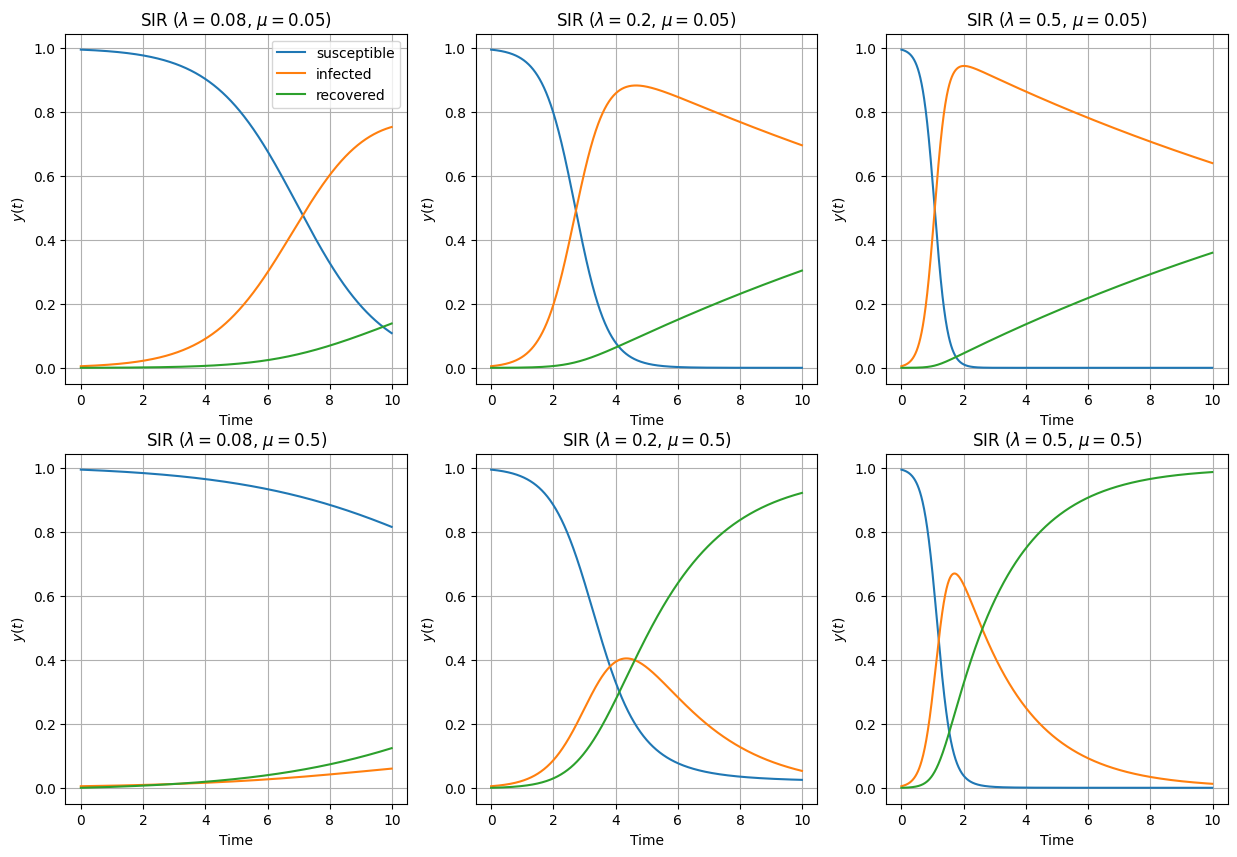

In [9]:
def sir_model(lmbd: float, k: float):
    """Construct a function that represents the SIR model"""
    def f(_t: float, y: np.ndarray) -> np.ndarray:
        s, i, r = y
        return np.array([
            -lmbd * k * i * s,
            lmbd * k * i * s - mu * i,
            mu * i
        ])
    return f

# Parameters for the numerical solution
num_steps = 1000
h = 0.01

lmbd_values = [0.08, 0.2, 0.5]
mu_values = [0.05, 0.5]
k = 10

infected = 0.005
y0 = np.array([1 - infected, infected, 0])

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Numerical solution
for ax, (mu, lmbd) in zip(axes.flat, it.product(mu_values, lmbd_values)):
    values = plot_method(runge_kutta, sir_model(lmbd, k), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, values, label=['susceptible', 'infected', 'recovered'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SIR ($\lambda = {lmbd}$, $\mu = {mu}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Modelo SEI (Susceptible-exposed-infected)

Agora, analisando a inclusão de um estado "exposto" ao modelo, obtemos o seguinte resultado:

## Equações diferenciais

$ \frac{ds}{dt} = -\lambda \left< k \right> is $  
$ \frac{de}{dt} = \lambda \left< k \right> is - \sigma e $  
$ \frac{di}{dt} = \sigma e $

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\sigma$ é a taxa em que indivíduos expostos se tornam infectados.
- $s$ é a fração da população suscetível à doença.
- $e$ é a fração da população exposta à doença, mas ainda não infectada.
- $i$ é a fração da população atualmente infectada.

## Plot do modelo SEI por solução numérica

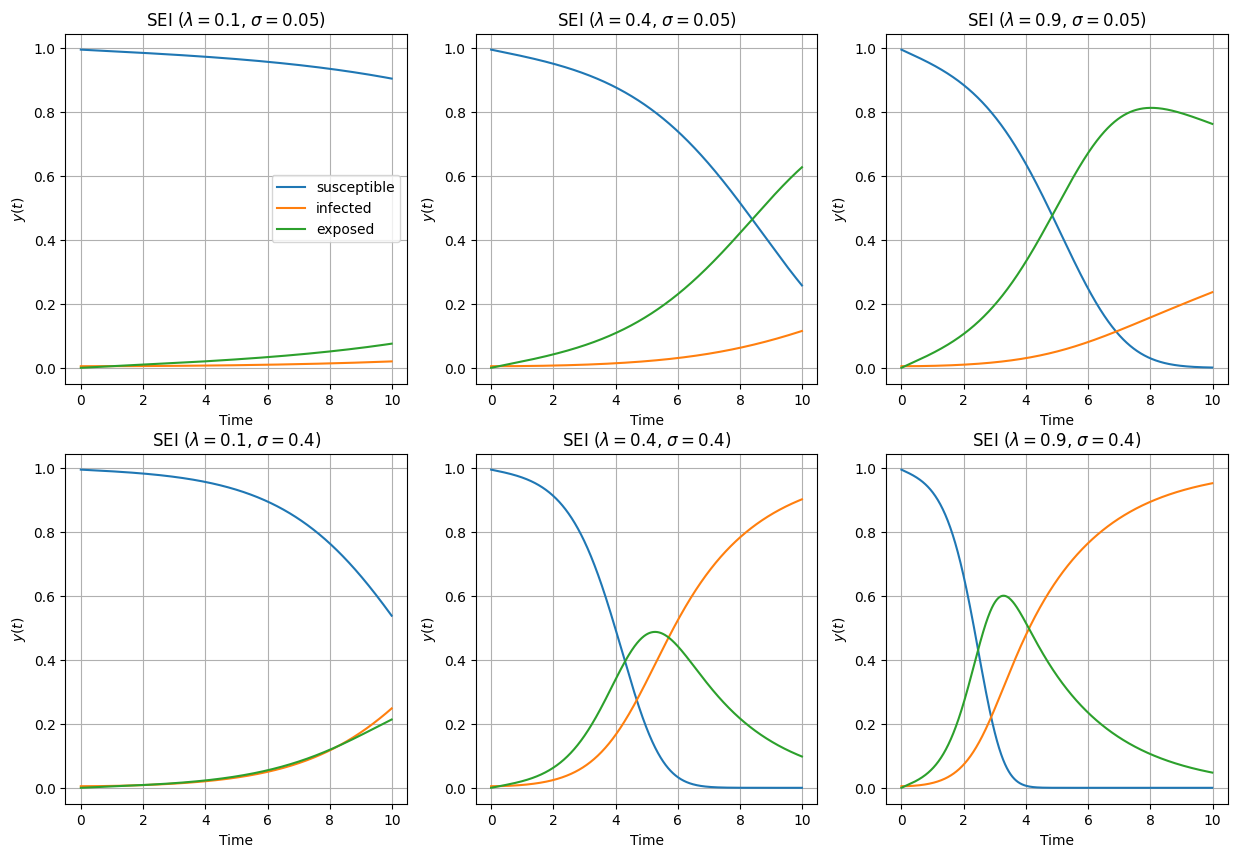

In [10]:
def sei_model(lmbd: float, k: float, sigma: float):
    """Construct a function that represents the SEI model."""
    def f(_t: float, y: np.ndarray) -> np.ndarray:
        s, i, e = y
        return np.array([
            -lmbd * k * i * s,
            sigma * e,
            lmbd * k * i * s - sigma * e,
        ])
    return f

# Parameters for the numerical solution
num_steps = 1000
h = 0.01

lmbd_values = [0.1, 0.4, 0.9]
sigma_values = [0.05, 0.4]
k = 10

infected = 0.005
y0 = np.array([1 - infected, infected, 0])

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Numerical solution
for ax, (sigma, lmbd) in zip(axes.flat, it.product(sigma_values, lmbd_values)):
    values = plot_method(runge_kutta, sei_model(lmbd, k, sigma), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, values, label=['susceptible', 'infected', 'exposed'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SEI ($\lambda = {lmbd}$, $\sigma = {sigma}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Modelo SEIS (Susceptible-exposed-infected-susceptible)

## Equações diferenciais

$ \frac{ds}{dt} = \mu i - \lambda\left< k \right>is $  
$ \frac{de}{dt} = \lambda\left< k \right>is - \sigma e $  
$ \frac{di}{dt} = \sigma e - \mu i $

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\sigma$ é a taxa em que indivíduos expostos se tornam infectados.
- $\mu$ é a taxa de cura.
- $s$ é a fração da população suscetível à doença.
- $e$ é a fração da população exposta à doença, mas ainda não infectada.
- $i$ é a fração da população atualmente infectada.

## Plot do modelo SEIS por solução numérica

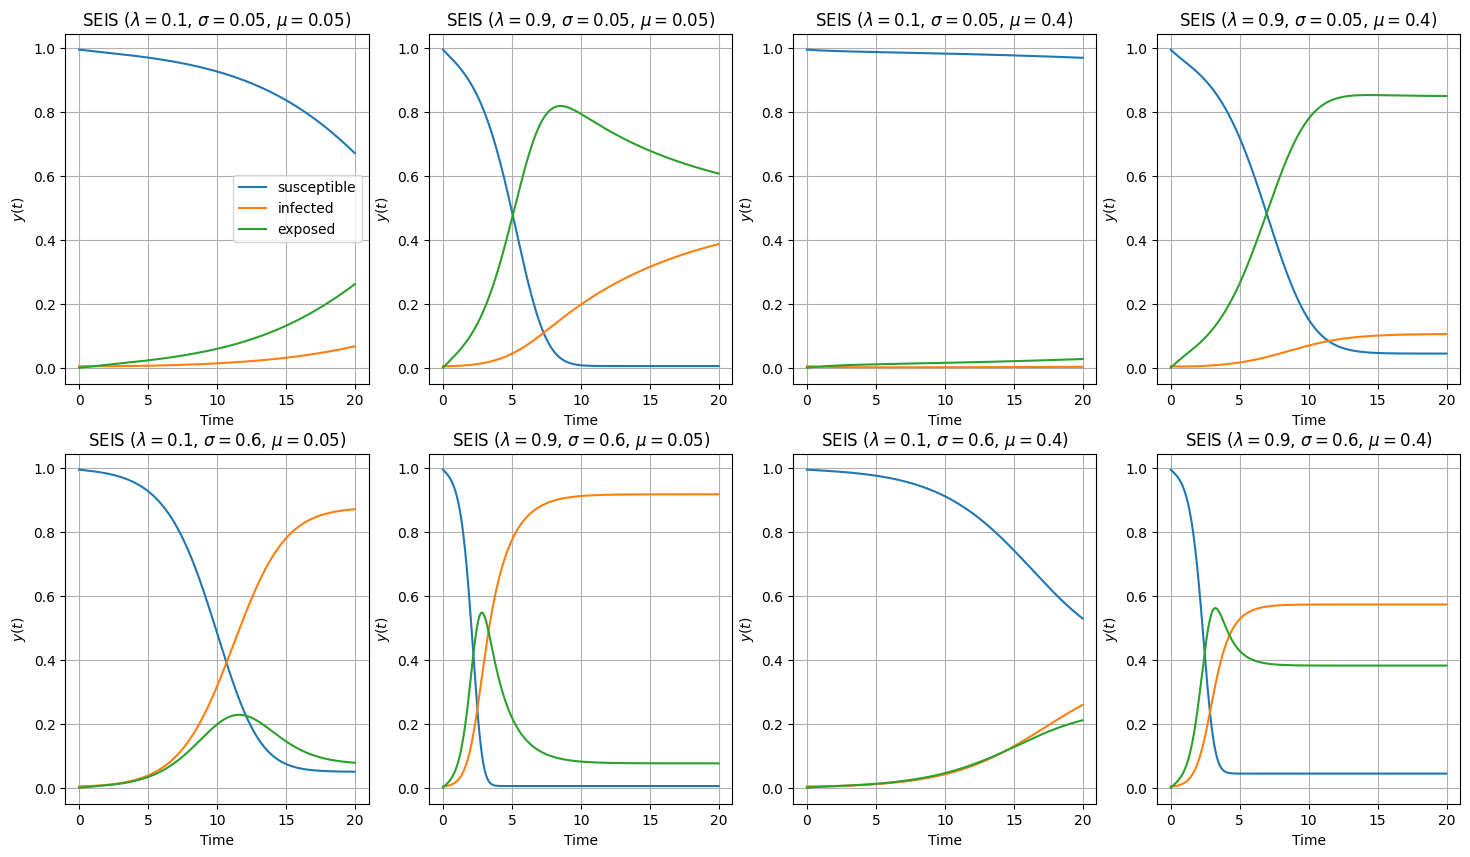

In [11]:
def seis_model(lmbd: float, k: float, sigma: float, mu: float):
    """Construct a function that represents the SEIS model."""
    def f(_t: float, y: np.ndarray) -> np.ndarray:
        s, i, e = y
        return np.array([
            mu * i - lmbd * k * i * s,
            sigma * e - mu * i,
            lmbd * k * i * s - sigma * e,
        ])
    return f

# Parameters for the numerical solution
num_steps = 2000
h = 0.01

lmbd_values = [0.1, 0.9]
sigma_values = [0.05, 0.6]
mu_values = [0.05, 0.4]
k = 10

infected = 0.005
y0 = np.array([1 - infected, infected, 0])

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Numerical solution
for ax, (sigma, mu, lmbd) in zip(axes.flat, it.product(sigma_values, mu_values, lmbd_values)):
    values = plot_method(runge_kutta, seis_model(lmbd, k, sigma, mu), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, values, label=['susceptible', 'infected', 'exposed'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SEIS ($\lambda = {lmbd}$, $\sigma = {sigma}$, $\mu = {mu}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Modelo SEIR (Susceptible-exposed-infected-recovered)

## Equações diferenciais

$ \frac{ds}{dt} = - \lambda\left< k \right>is $  
$ \frac{de}{dt} = \lambda\left< k \right>is - \sigma e $  
$ \frac{di}{dt} = \sigma e - \mu i $  
$ \frac{dr}{dt} = \mu i $

Onde:

- $\lambda$ é a taxa de transmissão da doença;
- $\left< k \right>$ é o número médio de contatos de cada indivíduo; e
- $\sigma$ é a taxa em que indivíduos expostos se tornam infectados.
- $\mu$ é a taxa de recuperação.
- $s$ é a fração da população suscetível à doença.
- $e$ é a fração da população exposta à doença, mas ainda não infectada.
- $i$ é a fração da população atualmente infectada.
- $r$ é a fração da população atualmente recuperada (ou removida).


## Plot do modelo SEIR por solução numérica

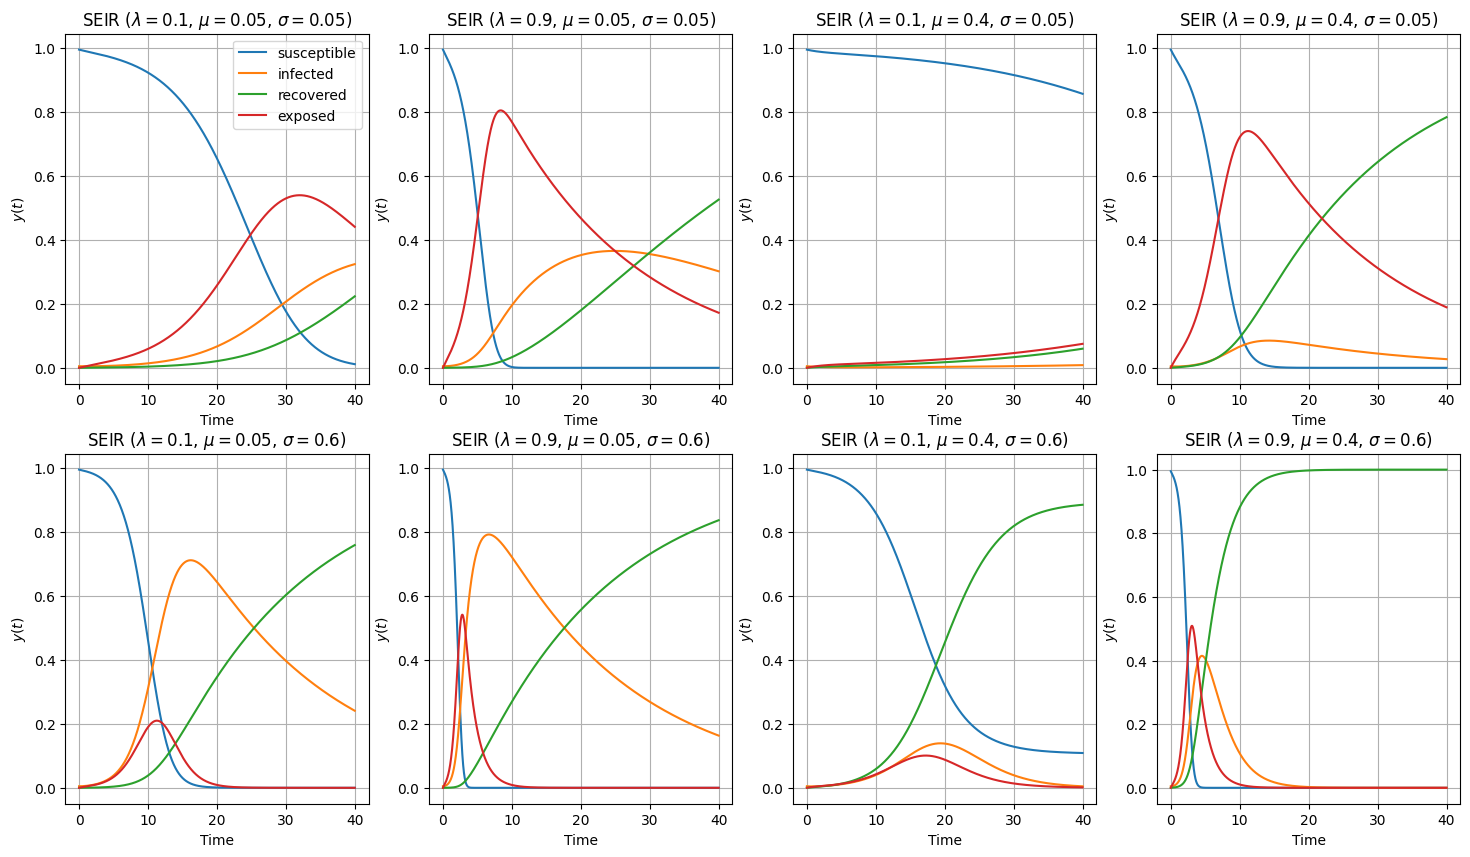

In [12]:
def seir_model(lmbd: float, k: float, sigma: float, mu: float):
    """Construct a function that represents the SEIR model."""
    def f(_t: float, y: np.ndarray) -> np.ndarray:
        s, i, r, e = y
        return np.array([
            -lmbd * k * i * s,
            sigma * e - mu * i,
            mu * i,
            lmbd * k * i * s - sigma * e,
        ])
    return f

# Parameters for the numerical solution
num_steps = 4000
h = 0.01

lmbd_values = [0.1, 0.9]
sigma_values = [0.05, 0.6]
mu_values = [0.05, 0.4]
k = 10

infected = 0.005
y0 = np.array([1 - infected, infected, 0, 0])

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Numerical solution
for ax, (sigma, mu, lmbd) in zip(axes.flat, it.product(sigma_values, mu_values, lmbd_values)):
    values = plot_method(runge_kutta, seir_model(lmbd, k, sigma, mu), y0, num_steps, h)

    # Plot the numerical solution
    ax.plot(time, values, label=['susceptible', 'infected', 'recovered', 'exposed'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SEIR ($\lambda = {lmbd}$, $\mu = {mu}$, $\sigma = {sigma}$)')
    ax.grid(True)

axes[0, 0].legend()
plt.show()

# Comparação entre modelos análogos, sem e com o estado exposto

## Modelo SIS e modelo SEIS

Parâmetros do modelo:

- $\lambda$ é a taxa de transmissão da doença;
- $\sigma$ é a taxa em que indivíduos expostos se tornam infectados.
- $\mu$ é a taxa de cura.

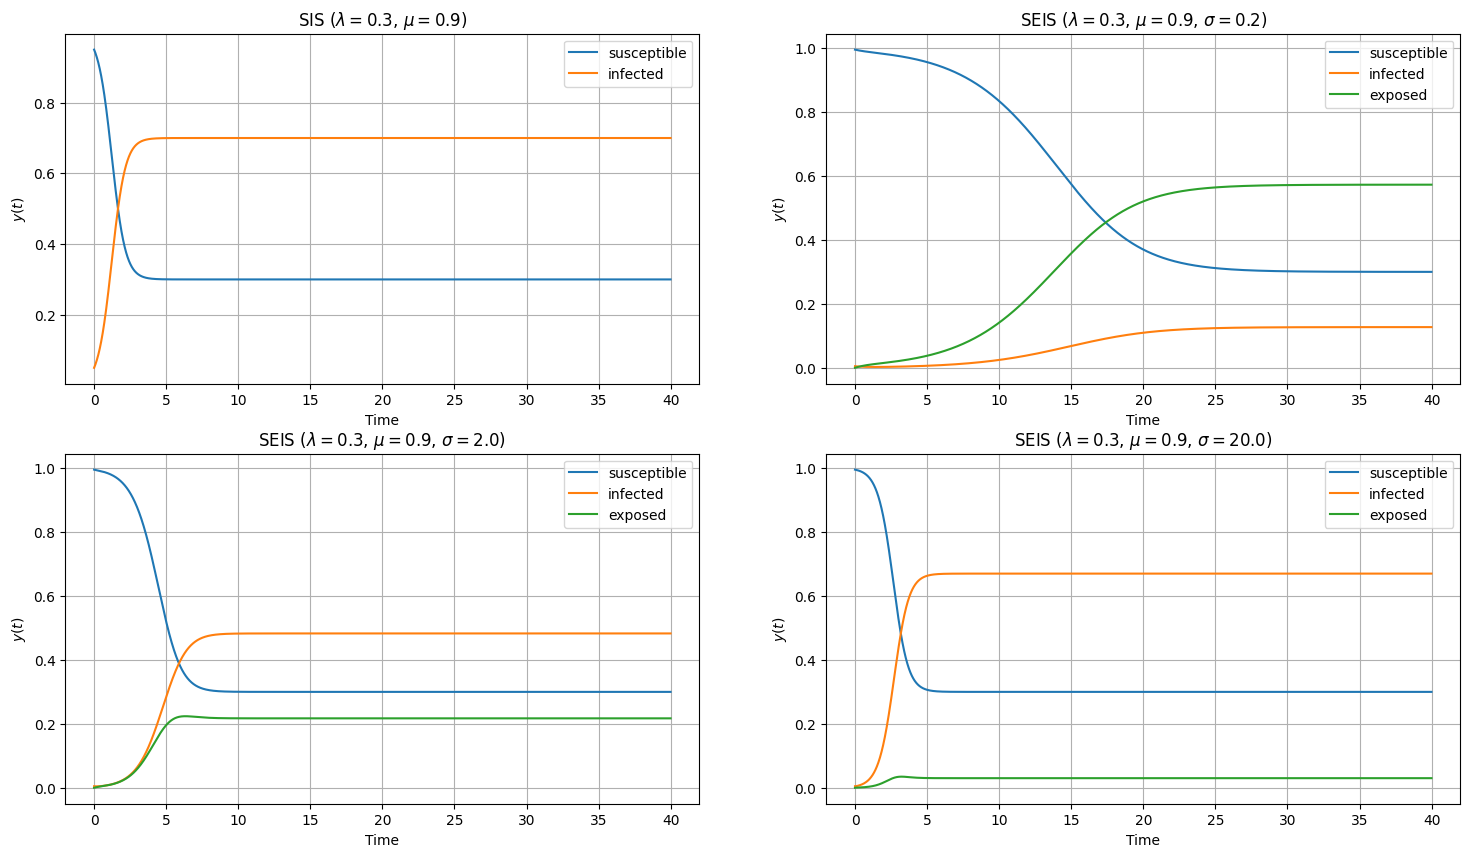

In [13]:
# Parameters for the numerical solution
num_steps = 4000
h = 0.01

lmbd = 0.3
sigma_values = [2e-1, 2e0, 2e1]
mu = 0.9
k = 10

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot SIS
y0 = 0.05
values = plot_method(runge_kutta, sis_model(lmbd, k, mu), y0, num_steps, h)

axes[0, 0].plot(time, 1 - values, label='susceptible')
axes[0, 0].plot(time, values, label='infected')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel(r'$y(t)$')
axes[0, 0].set_title(fr'SIS ($\lambda = {lmbd}$, $\mu = {mu}$)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot SEIS
infected = 0.005
y0 = np.array([1 - infected, infected, 0])

for ax, sigma in zip(axes.flat[1:], sigma_values):
    values = plot_method(runge_kutta, seis_model(lmbd, k, sigma, mu), y0, num_steps, h)

    ax.plot(time, values, label=['susceptible', 'infected', 'exposed'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SEIS ($\lambda = {lmbd}$, $\mu = {mu}$, $\sigma = {sigma}$)')
    ax.grid(True)
    ax.legend()

# Show plots
plt.show()

## Modelo SIR e modelo SEIR

Parâmetros do modelo:

- $\lambda$ é a taxa de transmissão da doença;
- $\sigma$ é a taxa em que indivíduos expostos se tornam infectados.
- $\mu$ é a taxa de recuperação.

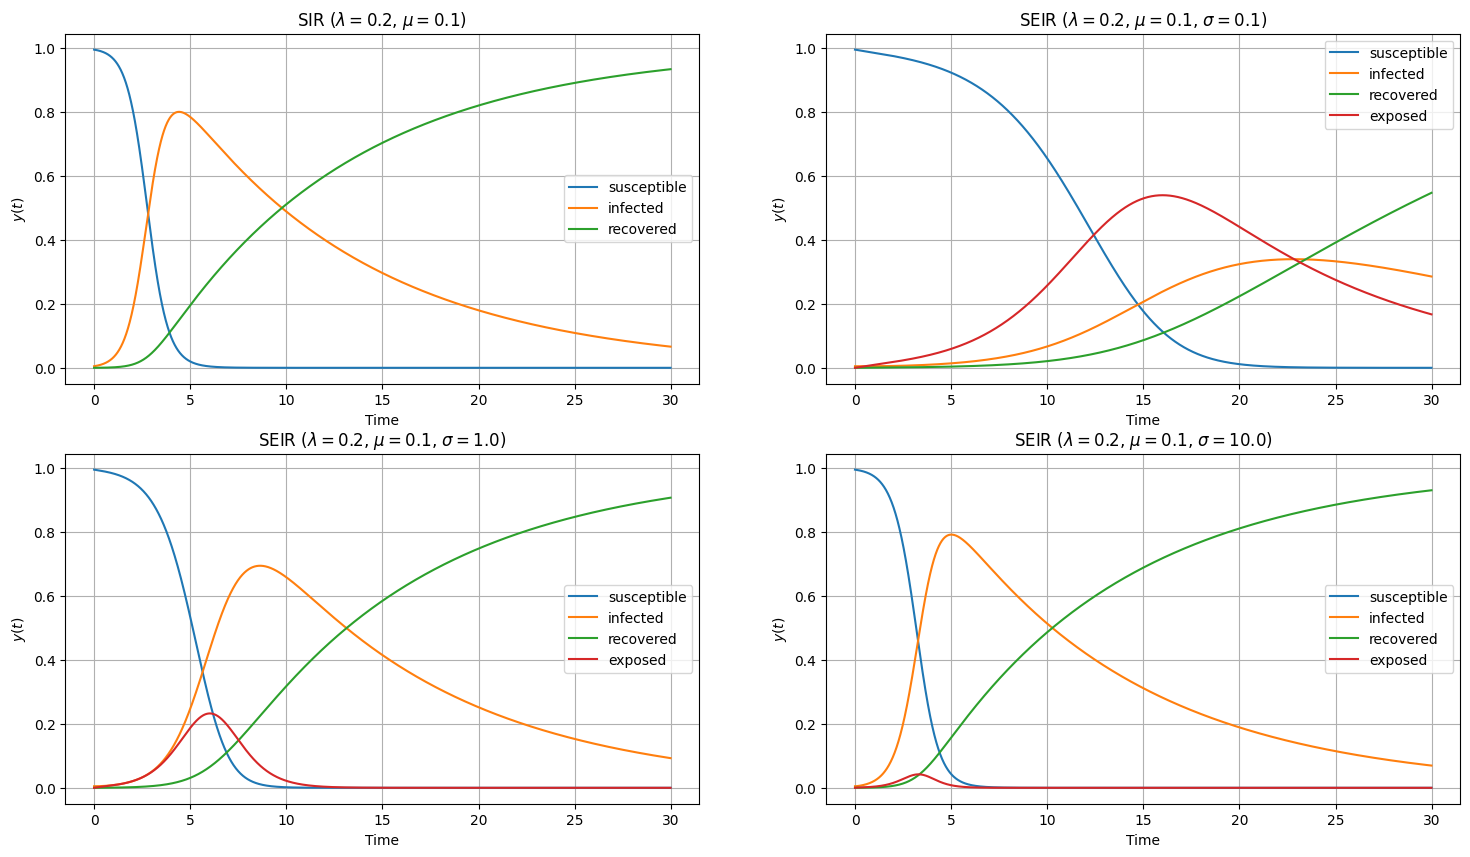

In [14]:
# Parameters for the numerical solution
num_steps = 3000
h = 0.01

lmbd = 0.2
sigma_values = [1e-1, 1e0, 1e1]
mu = 0.1
k = 10

time = np.arange(0, num_steps * h, h)

# Create the figure and axes objects
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot SIR
infected = 0.005
y0 = np.array([1 - infected, infected, 0])
values = plot_method(runge_kutta, sir_model(lmbd, k), y0, num_steps, h)

axes[0, 0].plot(time, values, label=['susceptible', 'infected', 'recovered'])
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel(r'$y(t)$')
axes[0, 0].set_title(fr'SIR ($\lambda = {lmbd}$, $\mu = {mu}$)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot SEIR
infected = 0.005
y0 = np.array([1 - infected, infected, 0, 0])

for ax, sigma in zip(axes.flat[1:], sigma_values):
    values = plot_method(runge_kutta, seir_model(lmbd, k, sigma, mu), y0, num_steps, h)

    ax.plot(time, values, label=['susceptible', 'infected', 'recovered', 'exposed'])
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$y(t)$')
    ax.set_title(fr'SEIR ($\lambda = {lmbd}$, $\mu = {mu}$, $\sigma = {sigma}$)')
    ax.grid(True)
    ax.legend()

# Show plots
plt.show()